# Exploring Ice Cream Shops 

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import math

import folium # map rendering library
from geopy.geocoders import Nominatim

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt

Retrieve Cities information (Name, main Postal Code, Square, Population) from database of Statistisches Bundesamt. 
Then calculate the approximate radius of cities (assuming they have round shape) and drop all cities with less than 50000 people population. 

In [2]:
cities = pd.read_csv("05-staedte.csv", sep=";", skiprows=7, nrows=2055, header=None, encoding = "ISO-8859-1")
# extract only relevant columns
cities = cities[[6,7,8,9]]
cities.columns = ['City', 'PostalCode', 'Square', 'Population']
cities['City'] = cities['City'].str.split(",").str[0]

# fix just one city name in order to find it in FourSquare and in zipcode file
cities['City']=cities['City'].str.replace("Bad Homburg v. d. Höhe", "Bad Homburg vor der Höhe", regex=False)
cities['City']=cities['City'].str.replace("Neumarkt i.d.OPf.", "Neumarkt in der Oberpfalz", regex=False)


cities['Population'] = cities['Population'].str.replace(",", ".").str.replace(" ", "")
cities['Square'] = cities['Square'].str.replace(",", ".")
cities = cities.astype({'Square':float, 'Population':float})

# calculare approximate radius depending on square
cities['Radius'] = np.sqrt(cities['Square']/math.pi)

# remove all the cities which are too small
cities = cities[cities['Population'] >= 50000]
print(cities.shape)
cities.head(10)

(191, 5)


,City,PostalCode,Square,Population,Radius
0,Berlin,10178,891.12,3669491.0,16.841980
1,Hamburg,20038,755.09,1847253.0,15.503310
2,München,80313,310.70,1484226.0,9.944792
3,Köln,50667,405.01,1087863.0,11.354237
4,Frankfurt am Main,60311,248.31,763380.0,8.890418
5,Stuttgart,70173,207.33,635911.0,8.123742
6,Düsseldorf,40213,217.41,621877.0,8.318879
7,Leipzig,4109,297.80,593145.0,9.736153
8,Dortmund,44135,280.71,588250.0,9.452659
9,Essen,45127,210.34,582760.0,8.182500


In [3]:
cities.tail(10)

,City,PostalCode,Square,Population,Radius
181,Wolfenbüttel,38300,78.74,52165.0,5.006368
182,Ibbenbüren,49477,108.87,51822.0,5.886799
183,Bad Kreuznach,55545,55.56,51170.0,4.205389
184,Gummersbach,51643,95.42,50952.0,5.511182
185,Ravensburg,88212,92.05,50897.0,5.412987
186,Speyer,67346,42.71,50561.0,3.687142
187,Goslar,38640,163.88,50554.0,7.222508
188,Willich,47877,67.80,50391.0,4.645580
189,Böblingen,71032,39.04,50161.0,3.525169
190,Erftstadt,50374,119.89,50010.0,6.177554


Also let's load Postal Code information and Latitude/Longitude Coordinates from database of Zauberware Repository

In [4]:
zipCodes = pd.read_json("zipcodes.de.json")
#zipCodes.rename(columns={'zipcode':'PostalCode'}, inplace = True)
zipCodes.head()

,country_code,zipcode,place,state,state_code,province,province_code,community,community_code,latitude,longitude
0,DE,1945,Grünewald,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4000,14.0000
1,DE,1945,Lindenau,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4000,13.7333
2,DE,1945,Hohenbocka,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4310,14.0098
3,DE,1945,Schwarzbach,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4500,13.9333
4,DE,1945,Guteborn,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4167,13.9333


Now let's add latitude and longitude coordinates from zipCodes database to the main city table of Statistisches Bundesamt. We try it first with postal code, but since not all postal codes are getting found, we also make a second try with name. 

In [5]:
for postalcode, city in zip(cities['PostalCode'], cities['City']):
    lookup_by_zip = zipCodes[zipCodes['zipcode']==postalcode]
    if len(lookup_by_zip) > 0:
        coordinates = lookup_by_zip[['latitude', 'longitude']]
        cities.loc[cities['City'] == city, ['Latitude', 'Longitude']] = [coordinates.iloc[0, 0], coordinates.iloc[0, 1]]
    else:     
        lookup_by_name = zipCodes[zipCodes['place']==city]
        if len(lookup_by_name) > 0:
            coordinates = lookup_by_name[['latitude', 'longitude']]
            cities.loc[cities['City'] == city, ['Latitude', 'Longitude']] = [coordinates.iloc[0, 0], coordinates.iloc[0, 1]]
        
print('Remaining cities without coordinates: {}'.format(cities['Latitude'].isna().sum()))
cities[cities['Latitude'].isna()]

Remaining cities without coordinates: 0


,City,PostalCode,Square,Population,Radius,Latitude,Longitude


In [6]:
# we just drop the remaining city
cities.dropna(inplace=True)
cities.shape

(191, 7)

Getting Ice Cream Shops for all German cities. For this we will use FourSquare API.

In [7]:
CLIENT_ID = 'AHPDQ1TXVT5VIXNH14HOY4ITAL3SXYEMMEAG3GOV3AWZIHJY' # your Foursquare ID
CLIENT_SECRET = '4TSGXZZI2O0DBMBKFRK0UZZ5DAHIXXT1P4CHPSZJKKJ1MENF' # your Foursquare Secret
VERSION = '20210802' # Foursquare API version

CATEGORY_ID = "4bf58dd8d48988d1c9941735"
LIMIT = 50 # A default Foursquare API limit value

URL_BY_NAME = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&near={}&radius={}&limit={}';
URL_BY_COORDS = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}';


In [8]:
def getIcecreamVenuesSummary(df):
    shops_list=[]
    for name, radius, lat, lon in zip(df['City'], df['Radius'], df['Latitude'], df['Longitude']):
        url = URL_BY_NAME.format(CLIENT_ID, CLIENT_SECRET, VERSION, CATEGORY_ID, name+", Germany", int(radius*1000), LIMIT)
        response = requests.get(url).json()["response"]
        if 'venues' in response:
            results = response['venues']
            shops_list.append([name, len(results)])
        else:
            url = URL_BY_COORDS.format(CLIENT_ID, CLIENT_SECRET, VERSION, CATEGORY_ID, lat, lon, int(radius*1000), LIMIT)
            response = requests.get(url).json()["response"]
            if 'venues' in response:
                results = response['venues']
                shops_list.append([name, len(results)])
            else:
                print("Couldn't find any Ice Shop by Coordinates for {}".format(name))
            
    df = pd.DataFrame(shops_list)
    df.columns = ["City", "IceCreamShopsAmount"]
    return df
    
iceCreamShops = getIcecreamVenuesSummary(df=cities)
iceCreamShops.head(10)

,City,IceCreamShopsAmount
0,Berlin,50
1,Hamburg,50
2,München,50
3,Köln,50
4,Frankfurt am Main,46
5,Stuttgart,42
6,Düsseldorf,50
7,Leipzig,42
8,Dortmund,48
9,Essen,37


Unfortunately, FourSquare API returns maximum 50 results for each city, so for the cities which have bigger amount of Ice Cream Shops we still don't know the exact amount of them. We have to proceed differently for such cities, calling API for different postal areas within these locations and then unifying results 

Let's figure out, how many cities are capped with 50 results.

In [9]:
bigCities = iceCreamShops[iceCreamShops['IceCreamShopsAmount'] == 50]
bigCities

,City,IceCreamShopsAmount
0,Berlin,50
1,Hamburg,50
2,München,50
3,Köln,50
6,Düsseldorf,50


Now let's do requests to FourSquare for those cities which have more than 50 Ice Cream Shops. 
This time we well call API with coordinates of latitude and longitude for each single Postal Code, and since we will often meet same Ice Cream Shops in different responces, we will save only unique results. 
After that, we will count the amount of these unique Ice Cream Shops.

In [11]:
def getIceShopsAmountPerCity(name, latitudes, longitudes, radius=1500):
    shops={}
    for lat, lng in zip(latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            CATEGORY_ID,
            lat, 
            lng,
            radius,
            LIMIT)
        # make the GET request
        response = requests.get(url).json()["response"]
        results = response['venues']
        for item in results:
            if 'city' in item['location'] and item['location']['city'] == name:
                shops[item['id']] = item
        
    return len(shops)

for city in bigCities['City']:
    codes = zipCodes[zipCodes['place']==city]
    iceShopsAmount = getIceShopsAmountPerCity(name=city, latitudes=codes['latitude'], longitudes=codes['longitude'])
    print('Found {} Ice Cream Shops for {}'.format(iceShopsAmount, city))
    iceCreamShops.loc[iceCreamShops['City'] == city, 'IceCreamShopsAmount'] = iceShopsAmount

Found 446 Ice Cream Shops for Berlin
Found 243 Ice Cream Shops for Hamburg
Found 169 Ice Cream Shops for München
Found 128 Ice Cream Shops for Köln
Found 79 Ice Cream Shops for Düsseldorf


And now let's check our ice cream table again

In [12]:
iceCreamShops.head(10)

,City,IceCreamShopsAmount
0,Berlin,446
1,Hamburg,243
2,München,169
3,Köln,128
4,Frankfurt am Main,46
5,Stuttgart,42
6,Düsseldorf,79
7,Leipzig,42
8,Dortmund,48
9,Essen,37


Let's merge to the final result column

In [13]:
citiesAndShops = cities.merge(iceCreamShops, on='City', how='left')
citiesAndShops.head(10)

,City,PostalCode,Square,Population,Radius,Latitude,Longitude,IceCreamShopsAmount
0,Berlin,10178,891.12,3669491.0,16.841980,52.5213,13.4096,446
1,Hamburg,20038,755.09,1847253.0,15.503310,53.5544,9.9946,243
2,München,80313,310.70,1484226.0,9.944792,48.1345,11.5710,169
3,Köln,50667,405.01,1087863.0,11.354237,50.9387,6.9547,128
4,Frankfurt am Main,60311,248.31,763380.0,8.890418,50.1112,8.6831,46
5,Stuttgart,70173,207.33,635911.0,8.123742,48.7786,9.1767,42
6,Düsseldorf,40213,217.41,621877.0,8.318879,51.2249,6.7743,79
7,Leipzig,4109,297.80,593145.0,9.736153,51.3420,12.3750,42
8,Dortmund,44135,280.71,588250.0,9.452659,51.5125,7.4770,48
9,Essen,45127,210.34,582760.0,8.182500,51.4535,7.0102,37


In [14]:
citiesAndShops.tail(10)

,City,PostalCode,Square,Population,Radius,Latitude,Longitude,IceCreamShopsAmount
181,Wolfenbüttel,38300,78.74,52165.0,5.006368,52.1578,10.5579,4
182,Ibbenbüren,49477,108.87,51822.0,5.886799,52.2601,7.7135,5
183,Bad Kreuznach,55545,55.56,51170.0,4.205389,49.8484,7.8378,8
184,Gummersbach,51643,95.42,50952.0,5.511182,51.0143,7.5724,3
185,Ravensburg,88212,92.05,50897.0,5.412987,47.7815,9.6183,7
186,Speyer,67346,42.71,50561.0,3.687142,49.3208,8.4311,11
187,Goslar,38640,163.88,50554.0,7.222508,51.9115,10.4319,5
188,Willich,47877,67.80,50391.0,4.645580,51.2637,6.5473,5
189,Böblingen,71032,39.04,50161.0,3.525169,48.6821,9.0117,13
190,Erftstadt,50374,119.89,50010.0,6.177554,50.8148,6.7939,4


Let's calculate amount of Ice Cream Shops per 10 Thousand Person Population

In [15]:
citiesAndShops['ShopsPer10TsdPerson'] = (citiesAndShops['IceCreamShopsAmount']/citiesAndShops['Population'])*10000
citiesAndShops.head(10)

,City,PostalCode,Square,Population,Radius,Latitude,Longitude,IceCreamShopsAmount,ShopsPer10TsdPerson
0,Berlin,10178,891.12,3669491.0,16.841980,52.5213,13.4096,446,1.215427
1,Hamburg,20038,755.09,1847253.0,15.503310,53.5544,9.9946,243,1.315467
2,München,80313,310.70,1484226.0,9.944792,48.1345,11.5710,169,1.138641
3,Köln,50667,405.01,1087863.0,11.354237,50.9387,6.9547,128,1.176619
4,Frankfurt am Main,60311,248.31,763380.0,8.890418,50.1112,8.6831,46,0.602583
5,Stuttgart,70173,207.33,635911.0,8.123742,48.7786,9.1767,42,0.660470
6,Düsseldorf,40213,217.41,621877.0,8.318879,51.2249,6.7743,79,1.270348
7,Leipzig,4109,297.80,593145.0,9.736153,51.3420,12.3750,42,0.708090
8,Dortmund,44135,280.71,588250.0,9.452659,51.5125,7.4770,48,0.815980
9,Essen,45127,210.34,582760.0,8.182500,51.4535,7.0102,37,0.634910


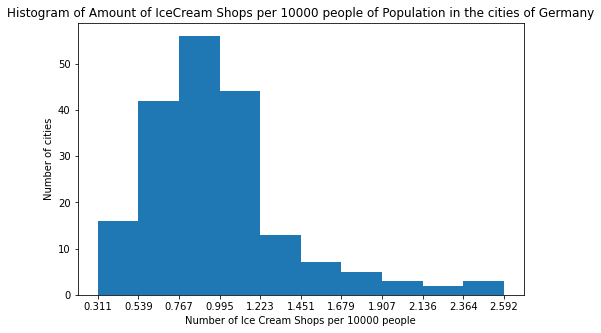

In [16]:
count, bin_edges = np.histogram(citiesAndShops['ShopsPer10TsdPerson'])

citiesAndShops['ShopsPer10TsdPerson'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Amount of IceCream Shops per 10000 people of Population in the cities of Germany')
plt.ylabel('Number of cities') 
plt.xlabel('Number of Ice Cream Shops per 10000 people') 

plt.show()

Also let's see if amount of Ice Cream Shops per 10000 Person correlates somehow with Total population of city (i.e. smaller cities have proportionally more Ice Cream Shops or other way around). 

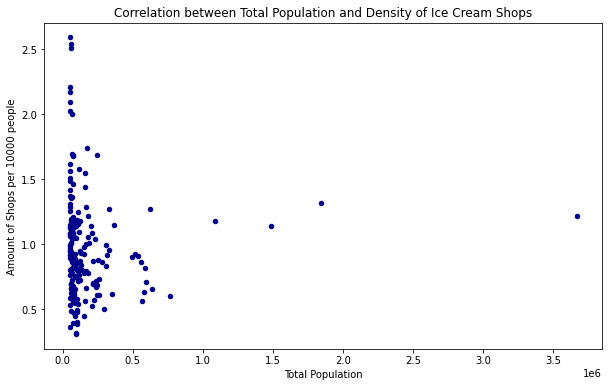

In [29]:
citiesAndShops.plot(kind='scatter', x='Population', y='ShopsPer10TsdPerson', figsize=(10, 6), color='darkblue')

plt.title('Correlation between Total Population and Density of Ice Cream Shops')
plt.xlabel('Total Population')
plt.ylabel('Amount of Shops per 10000 people')

plt.show()

We can notice that bigger cities (with population above 1 Million) have pretty same density of Ice Cream Shops per 10 000 population: around 1,3 shops. The smallest cities have very different density (from close to 0 up to 2,5 Shops per 10000), however with growing of size of the city the density of shops has tendence to decline.  

Now let's see how the density of shops correlates with geographical coordinates 

Text(0.5, 1.0, 'Distribution of geographical density of Ice Cream Shops')

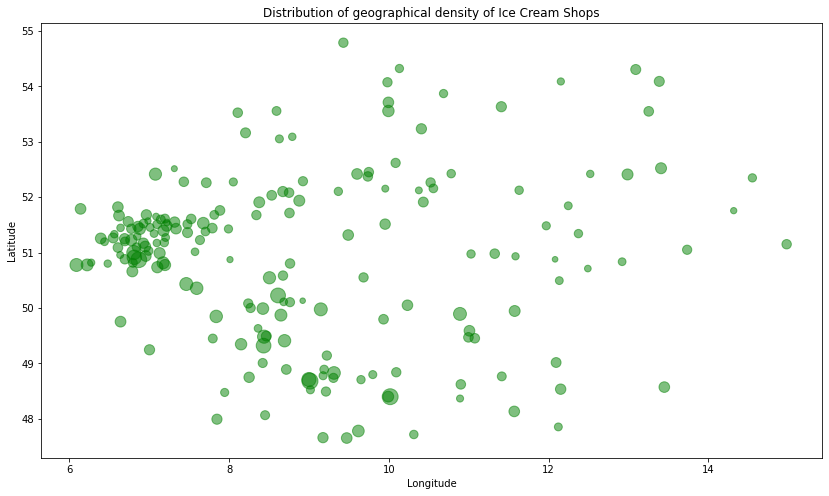

In [34]:
ax0 = citiesAndShops.plot(kind='scatter',
                    x='Longitude',
                    y='Latitude',
                    figsize=(14, 8),
                    alpha=0.5,  # transparency
                    color='green',
                    s=citiesAndShops['ShopsPer10TsdPerson']*100,  # pass in weights 
                    )

ax0.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')
ax0.set_title('Distribution of geographical density of Ice Cream Shops')


It looks like the cities in West and South Germany have tendence to have more shops per 10 000 Population as in East Germany. 

Finally, let's find out which cities have the highest density of Ice Cream Shops per Population, and which - the smallest. 

In [28]:
citiesAndShopsSorted = cities_for_clustering.sort_values(by='ShopsPer10TsdPerson', ascending=True)
citiesAndShopsSorted.head(10)

,Cluster Labels,Population,Latitude,Longitude,ShopsPer10TsdPerson,City
82,1,96492.0,50.1316,8.9208,0.310907,Hanau
87,4,93125.0,50.8782,12.0824,0.322148,Gera
166,2,54708.0,52.5138,7.3133,0.365577,Lingen (Ems)
77,2,102770.0,50.8734,8.0104,0.389219,Siegen
112,2,75610.0,51.5713,6.9827,0.396773,Gladbeck
81,4,99678.0,51.7560,14.3197,0.401292,Cottbus/Chó?ebuz
52,2,156449.0,51.5426,7.2190,0.447430,Herne
93,4,88690.0,50.7114,12.4928,0.451009,Zwickau
98,2,84067.0,51.6484,7.0845,0.475811,Marl
75,4,104291.0,52.1221,10.3761,0.479428,Salzgitter


In [27]:
citiesAndShopsSorted.tail(10)

,City,PostalCode,Square,Population,Radius,Latitude,Longitude,IceCreamShopsAmount,ShopsPer10TsdPerson
135,Neuwied,56564,86.50,64765.0,5.247266,50.4326,7.4630,11,1.698448
44,Ludwigshafen am Rhein,67059,77.43,172253.0,4.964548,49.4828,8.4376,30,1.741624
134,Sindelfingen,71063,50.83,64905.0,4.022399,48.7094,8.9988,13,2.002927
171,Pulheim,50259,72.15,54194.0,4.792292,50.9996,6.8063,11,2.029745
179,Frechen,50226,45.06,52439.0,3.787221,50.9149,6.8118,11,2.097675
186,Speyer,67346,42.71,50561.0,3.687142,49.3208,8.4311,11,2.175590
170,Bad Homburg vor der Höhe,61343,51.14,54227.0,4.034646,50.2265,8.6120,12,2.212920
148,Hürth,50354,51.22,59731.0,4.037800,50.8708,6.8676,15,2.511259
152,Neu-Ulm,89210,80.95,58978.0,5.076139,48.4000,10.0167,15,2.543321
189,Böblingen,71032,39.04,50161.0,3.525169,48.6821,9.0117,13,2.591655


#### Cluster cities in 5 clusters

In [23]:
# set number of clusters
kclusters = 5

cities_for_clustering = citiesAndShops[['Population', 'Latitude', 'Longitude', 'ShopsPer10TsdPerson']]

clus_dataSet = StandardScaler().fit_transform(cities_for_clustering)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clus_dataSet)
# check cluster labels generated for each row in the dataframe

# add clustering labels
cities_for_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
cities_for_clustering['City'] = citiesAndShops['City']
cities_for_clustering.head()

C:\Users\sunbe\anaconda3\envs\LearnDataScience\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Cluster Labels,Population,Latitude,Longitude,ShopsPer10TsdPerson,City
0,3,3669491.0,52.5213,13.4096,1.215427,Berlin
1,3,1847253.0,53.5544,9.9946,1.315467,Hamburg
2,3,1484226.0,48.1345,11.5710,1.138641,München
3,2,1087863.0,50.9387,6.9547,1.176619,Köln
4,1,763380.0,50.1112,8.6831,0.602583,Frankfurt am Main


#### Creating Map of Cities

In [24]:
address = 'Germany'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Germany are {}, {}.'.format(latitude, longitude))
# create map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, cluster in zip(cities_for_clustering['Latitude'], cities_for_clustering['Longitude'], cities_for_clustering['City'], cities_for_clustering['Cluster Labels']):
    if not math.isnan(cluster):
        label = folium.Popup(city+' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Germany are 51.0834196, 10.4234469.


Now let's examine every of 5 Clusters separately

__Cluster 0__

In [39]:
cluster_0 = cities_for_clustering[cities_for_clustering['Cluster Labels']==0].drop('Cluster Labels', axis=1)
cluster_0.describe()

,Population,Latitude,Longitude,ShopsPer10TsdPerson
count,22.000000,22.000000,22.000000,22.000000
mean,84945.045455,49.895291,8.268968,1.821274
std,53025.048234,0.792051,1.132831,0.388698
min,50161.000000,48.400000,6.087200,1.314208
25%,53496.500000,49.362250,7.495550,1.551953
50%,62248.000000,49.934550,8.434350,1.688556
75%,76768.000000,50.517275,8.922475,2.080693
max,248960.000000,50.999600,10.891100,2.591655


__Cluster 1__

In [40]:
cluster_1 = cities_for_clustering[cities_for_clustering['Cluster Labels']==1].drop('Cluster Labels', axis=1)
cluster_1.describe()

,Population,Latitude,Longitude,ShopsPer10TsdPerson
count,43.000000,43.000000,43.000000,43.000000
mean,161538.511628,48.980653,9.648977,0.881433
std,155403.033284,0.771887,1.404384,0.212789
min,50897.000000,47.654400,7.002200,0.310907
25%,68893.000000,48.508600,8.574200,0.735523
50%,100030.000000,48.840900,9.306100,0.869255
75%,166734.000000,49.541100,10.602650,1.045726
max,763380.000000,50.551800,13.450600,1.375327


The most important difference is that Cluster 1 groups cities with significantly smaller density of Shops as Cluster 0. (Mean of 0,88 vs 1,82) and standard distribution of 0,21. Thus it can make sence to concentrate on cities of Cluster 1 to open new Ice Cream Shops.

In [41]:
cluster_2 = cities_for_clustering[cities_for_clustering['Cluster Labels']==2].drop('Cluster Labels', axis=1)
cluster_2.describe()

,Population,Latitude,Longitude,ShopsPer10TsdPerson
count,8.200000e+01,82.000000,82.000000,82.000000
mean,1.448037e+05,51.491001,7.347056,0.904752
std,1.630449e+05,0.622351,0.753665,0.264303
min,5.001000e+04,49.753700,6.138600,0.365577
25%,6.165600e+04,51.170250,6.788875,0.721842
50%,8.177900e+04,51.430450,7.136450,0.919197
75%,1.585460e+05,51.679325,7.769900,1.134624
max,1.087863e+06,53.554500,9.491200,1.489453


Cluster 2 has also not too high density of shops, but the cities are placed more at north of Germany.

In [42]:
cluster_3 = cities_for_clustering[cities_for_clustering['Cluster Labels']==3].drop('Cluster Labels', axis=1)
cluster_3.describe()

,Population,Latitude,Longitude,ShopsPer10TsdPerson
count,3.000000e+00,3.000000,3.000000,3.000000
mean,2.333657e+06,51.403400,11.658400,1.223178
std,1.171020e+06,2.877691,1.709177,0.088668
min,1.484226e+06,48.134500,9.994600,1.138641
25%,1.665740e+06,50.327900,10.782800,1.177034
50%,1.847253e+06,52.521300,11.571000,1.215427
75%,2.758372e+06,53.037850,12.490300,1.265447
max,3.669491e+06,53.554400,13.409600,1.315467


Cluster 3 contains just 3 cities, and these are the cities with very high total population 

In [43]:
cluster_4 = cities_for_clustering[cities_for_clustering['Cluster Labels']==4].drop('Cluster Labels', axis=1)
cluster_4.describe()

,Population,Latitude,Longitude,ShopsPer10TsdPerson
count,41.000000,41.000000,41.000000,41.000000
mean,158051.707317,52.365302,11.432985,0.777885
std,149784.903720,1.165020,1.568964,0.222694
min,50554.000000,50.494200,8.790600,0.322148
25%,64597.000000,51.483000,10.085000,0.619224
50%,93125.000000,52.264700,11.326300,0.723641
75%,213981.000000,53.232900,12.492800,0.919850
max,593145.000000,54.786200,14.982900,1.219959


Cluster 4 has even smaller density of Ice Cream Shops per 10000 than Cluster 2 (mean of 0.78), and all these cities are geographically placed in East Germany.

__Conclusion__
The geographical clustering of Ice Cream Shops would allow the efficient planing of regional franchising sets based on location. Each cluster can be examined on the most promising cities based on list of cities with smallest densities. 

In [56]:
cl1 = cluster_1[['City', 'ShopsPer10TsdPerson']].sort_values(by='ShopsPer10TsdPerson').reset_index()
cl2 = cluster_2[['City', 'ShopsPer10TsdPerson']].sort_values(by='ShopsPer10TsdPerson').reset_index()
cl4 = cluster_4[['City', 'ShopsPer10TsdPerson']].sort_values(by='ShopsPer10TsdPerson').reset_index()
final_table=pd.concat([cl1, cl2, cl4], axis=1)
final_table.drop('index', axis=1, inplace=True)
final_table.columns=['Best Cities of South Germany', 'Density', 'Best Cities of North Germany', 'Density', 'Best Cities of East Germany', 'Density']
final_table.head(10)

,Best Cities of South Germany,Density,Best Cities of North Germany,Density,Best Cities of East Germany,Density
0,Hanau,0.310907,Lingen (Ems),0.365577,Gera,0.322148
1,Augsburg,0.505762,Siegen,0.389219,Cottbus/Chó?ebuz,0.401292
2,Worms,0.598501,Gladbeck,0.396773,Zwickau,0.451009
3,Frankfurt am Main,0.602583,Herne,0.447430,Salzgitter,0.479428
4,Rosenheim,0.629416,Marl,0.475811,Hildesheim,0.491676
5,Schwäbisch Gmünd,0.654268,Bergheim,0.487005,Rostock,0.525835
6,Tübingen,0.655695,Eschweiler,0.531143,Jena,0.538875
7,Stuttgart,0.660470,Düren,0.548149,Brandenburg an der Havel,0.554139
8,Offenburg,0.667034,Solingen,0.565167,Bremen,0.563818
9,Göppingen,0.691886,Ratingen,0.571298,Chemnitz,0.608929


__Note:__
What this model unfortunately doesn't consider yet, is the flow of tourists for each city. The given analysis is based purely on own population of the cities, i.e. local ice consumers. However big flows of tourists can impact the profitability of Ice Cream Shops significantly. Thus it would make sence to extend the analysis also to this aspect of cities profile, which however is not in scope of this project.